In [1]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !                                !
# ! Exact name of current notebook !
# !                                !
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
nb_name = 'ProteoGAN_22.03.ipynb'

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import time
import datetime
import zipfile
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
TRAIN_DATA_FILE = "../dataset/dataPS_5.csv"

# Number of training epochs
NUM_EPOCHS = 3000

# Maximum protein chain length
MAX_ATOMS = 150

# Total prediction sequence length (2 angles per atom)
SEQ_LEN = MAX_ATOMS * 2

# Number of structures to predict
N_STRUCTURES = 10

# Destination path for data output
DEST = 'output'

# Model destination
MODEL_DEST = 'models'

# ZIP files destination
ZIP_DEST = 'zip'

# Cleanup required (elimination of model and output folders after zipping)?
CLEANUP = True

In [4]:
class ModelConfig(object):
    def __init__(self):
        self.num_layers = 1  # Number of LSTM layers
        self.rnn_size = 64  # Number of LSTM units
        self.hidden_size = 32  # Number of hidden layer units
        self.num_mixtures = 4
        self.batch_size = 4
        self.num_steps = 10
        self.dropout_rate = 0.5  # Dropout rate
        self.learning_rate = 0.001  # Learning rate 

In [5]:
train_config = ModelConfig()
train_config.learning_rate = 0.0003

test_config = ModelConfig()
test_config.batch_size = 1
test_config.num_steps = 1

In [6]:
# Prepare label
label = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
label

'2019-02-27_22-55-45'

In [7]:
# Cleanup model and prediction data if needed
if CLEANUP:
    if os.path.exists(MODEL_DEST):
        shutil.rmtree(MODEL_DEST)
    if os.path.exists(DEST):
        shutil.rmtree(DEST)

In [8]:
def load_training_data():
    """ Returns a matrix of training data.
    shape of result = (n_exp, len)
    """
    data = pd.read_csv(TRAIN_DATA_FILE, index_col=0, sep=';')

    # Remove names
    data.drop(data.columns[0], axis=1, inplace=True)

    # Normalize by row
    data = data.div(data.abs().max(axis=1), axis=0)

    return data.values

In [9]:
class DataLoader(object):
    def __init__(self, data, batch_size=128, num_steps=1):
        self.batch_size = batch_size
        self.n_data, self.seq_len = data.shape
        self._data = data[:self.batch_size , :]
        
        self.num_steps = num_steps
        self._data = self._data.reshape((self.batch_size, self.seq_len, 1))
        self._reset_pointer()

    def _reset_pointer(self):
        self.pointer = 0 

    def reset(self):
        self._reset_pointer()

    def has_next(self):
        return self.pointer + self.num_steps < self.seq_len - 1

    def next_batch(self):
       batch_xs = self._data[:, self.pointer:self.pointer+self.num_steps, :]
       batch_ys = self._data[:, self.pointer+1:self.pointer+self.num_steps+1, :]
       self.pointer = self.pointer + self.num_steps
       return batch_xs, batch_ys 

In [10]:
def reset_session_and_model():
    """
    Resets the TensorFlow default graph and session.
    """
    tf.reset_default_graph()
    sess = tf.get_default_session()
    if sess:
        sess.close()

In [11]:
class MDNModel(object):
    def __init__(self, config, is_training=True):
        self.batch_size = config.batch_size
        self._config = config
        self.rnn_size = config.rnn_size
        self.num_layers = config.num_layers
        self.hidden_size = config.hidden_size
        self.num_steps = config.num_steps
        self.num_mixtures = config.num_mixtures
        self.n_gmm_params = self.num_mixtures * 3
        self.learning_rate = config.learning_rate
        self.is_training = is_training
        with tf.variable_scope('mdn_model', reuse=(not self.is_training)):
            self._build_model()
    

    def _build_model(self):
        """ Build the MDN Model"""
        self.x_holder = tf.placeholder(tf.float32, [self.batch_size, self.num_steps, 1 ], name="x")
        self.y_holder = tf.placeholder(tf.float32, [self.batch_size, self.num_steps, 1], name="y")
        
        multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(
                [tf.nn.rnn_cell.LSTMCell(self.rnn_size) for _ in range(self.num_layers)], state_is_tuple=True)
        self.init_state = multi_rnn_cell.zero_state(self.batch_size, tf.float32)
        
        rnn_outputs, self.final_state = tf.nn.dynamic_rnn(cell=multi_rnn_cell,
                                                     inputs=self.x_holder,
                                                     initial_state=self.init_state)
        
        w1 = tf.get_variable('w1', shape=[self.rnn_size, self.hidden_size], dtype=tf.float32,
                            initializer=tf.truncated_normal_initializer(stddev=0.2))
        b1 = tf.get_variable('b1', shape=[self.hidden_size], dtype=tf.float32, 
                            initializer=tf.constant_initializer())
        h1 = tf.nn.sigmoid(tf.matmul(tf.reshape(rnn_outputs, [-1, self.rnn_size]), w1) + b1)
        w2 = tf.get_variable('w2', shape=[self.hidden_size, self.n_gmm_params], dtype=tf.float32,
                             initializer=tf.truncated_normal_initializer(stddev=0.2))
        b2 = tf.get_variable('b2', shape=[self.n_gmm_params], dtype=tf.float32,
                             initializer=tf.constant_initializer())
        gmm_params = tf.matmul(h1, w2) + b2
        print(gmm_params)
        mu_ = gmm_params[:, : self.num_mixtures]
        sigma_= gmm_params[:,  self.num_mixtures: 2* self.num_mixtures]
        pi_ = gmm_params[:,  2*self.num_mixtures:]
        self.mu = mu_
        self.sigma = tf.exp(sigma_ / 2.0)
        self.pi = tf.nn.softmax(pi_)
        print(self.mu)
        print(self.sigma)
        if self.is_training:
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
            print(self.y_holder)
            mixture_p = tf.contrib.distributions.Normal(self.mu, self.sigma).prob(tf.reshape(self.y_holder,(-1,1)))
            mixture_p = tf.multiply(self.pi, mixture_p)
            output_p = tf.reduce_sum(mixture_p, reduction_indices=1, keepdims=True)
            log_output_p = tf.log(output_p)
            mean_log_output_p = tf.reduce_mean(log_output_p)
            self.loss = -mean_log_output_p   
            self.train_op = self.optimizer.minimize(self.loss)
            
     
    def train_for_epoch(self, sess, data_loader):
        assert self.is_training, "Must be training model"
        cur_state = sess.run(self.init_state)
        data_loader.reset()
        epoch_loss = []
        while data_loader.has_next():
            batch_xs, batch_ys = data_loader.next_batch()
            batch_xs = batch_xs.reshape((self.batch_size, self.num_steps, 1))
            batch_ys = batch_ys.reshape((self.batch_size, self.num_steps, 1))
            _, batch_loss_, new_state_ = sess.run(
                [self.train_op, self.loss, self.final_state],
                feed_dict = {
                    self.x_holder: batch_xs,
                    self.y_holder: batch_ys,
                    self.init_state: cur_state,
                })
            cur_state = new_state_
            epoch_loss.append(batch_loss_)
         
            
        return np.mean(epoch_loss)
    
    
    def predict(self,sess, seq_len=1000):
        assert not self.is_training, "Must be testing model"
        cur_state = sess.run(self.init_state)
        preds = []
        preds.append(np.random.uniform())
        for step in range(seq_len):
            batch_xs = np.array(preds[-1]).reshape((self.batch_size, self.num_steps, 1))
            mu_, sigma_, pi_, new_state_ = sess.run(
                [self.mu, self.sigma, self.pi, self.final_state],
                feed_dict = {
                    self.x_holder: batch_xs,
                    self.init_state: cur_state
                }
            )
            # chose one
            select_mixture = np.random.choice(self.num_mixtures, p=pi_[0])
            new_pred_ = np.random.normal(loc=mu_[0][select_mixture], scale=sigma_[0][select_mixture])
            preds.append(new_pred_)
            cur_state = new_state_
        return preds[1:]

In [12]:
data = load_training_data()

In [13]:
reset_session_and_model()
with tf.Session() as sess:
    loader = DataLoader(data=data, batch_size=train_config.batch_size, num_steps=train_config.num_steps)
    train_model = MDNModel(train_config, True)
    test_model = MDNModel(test_config, False)
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(max_to_keep=0)
    for idx in range(NUM_EPOCHS):
        epoch_loss = train_model.train_for_epoch(sess, loader)
        print(idx, ' ', epoch_loss)
        if (idx+1) % 100 == 0:
            saver.save(sess, f'{MODEL_DEST}/mdnmodel_{label}.ckpt')

Tensor("mdn_model/add_1:0", shape=(40, 12), dtype=float32)
Tensor("mdn_model/strided_slice:0", shape=(40, 4), dtype=float32)
Tensor("mdn_model/Exp:0", shape=(40, 4), dtype=float32)
Tensor("mdn_model/y:0", shape=(4, 10, 1), dtype=float32)
Tensor("mdn_model_1/add_1:0", shape=(1, 12), dtype=float32)
Tensor("mdn_model_1/strided_slice:0", shape=(1, 4), dtype=float32)
Tensor("mdn_model_1/Exp:0", shape=(1, 4), dtype=float32)
0   0.88908696
1   0.6097901
2   0.085973695
3   -0.18591172
4   -0.3329
5   -0.4305798
6   -0.5039391
7   -0.56538624
8   -0.61738145
9   -0.65981954
10   -0.6966222
11   -0.73066854
12   -0.7597718
13   -0.78344923
14   -0.8024349
15   -0.81725377
16   -0.82870364
17   -0.8375637
18   -0.8445074
19   -0.8500839
20   -0.8547165
21   -0.85872877
22   -0.8623617
23   -0.8657718
24   -0.86902416
25   -0.8721292
26   -0.8751121
27   -0.878064
28   -0.881059
29   -0.8840996
30   -0.887226
31   -0.89045286
32   -0.893802
33   -0.8972795
34   -0.9008816
35   -0.9045771
36   -0.

439   -1.6419499
440   -1.6228938
441   -1.6505218
442   -1.6356447
443   -1.6156951
444   -1.6465806
445   -1.6262791
446   -1.6302159
447   -1.6554713
448   -1.6325685
449   -1.6493899
450   -1.6601312
451   -1.6277791
452   -1.6260709
453   -1.6371218
454   -1.5760071
455   -1.6445844
456   -1.6592313
457   -1.6370465
458   -1.6547275
459   -1.6593822
460   -1.631921
461   -1.6576638
462   -1.6633089
463   -1.6335378
464   -1.6511469
465   -1.6526256
466   -1.6170064
467   -1.6637056
468   -1.6658155
469   -1.6502211
470   -1.6633267
471   -1.6231464
472   -1.6291553
473   -1.6630187
474   -1.6448966
475   -1.645128
476   -1.627798
477   -1.5840895
478   -1.5768974
479   -1.6063174
480   -1.5609124
481   -1.4681607
482   -1.530511
483   -1.6103033
484   -1.6557212
485   -1.6655375
486   -1.6677171
487   -1.6702516
488   -1.6744941
489   -1.6770868
490   -1.6770285
491   -1.6764759
492   -1.6768751
493   -1.6781535
494   -1.6778207
495   -1.6764793
496   -1.6748554
497   -1.6757026
4

899   -1.7565868
INFO:tensorflow:models/mdnmodel_2019-02-27_22-55-45.ckpt is not in all_model_checkpoint_paths. Manually adding it.
900   -1.7912374
901   -1.6944755
902   -1.7588272
903   -1.6767815
904   -1.7633761
905   -1.7835088
906   -1.6820581
907   -1.7699652
908   -1.7488708
909   -1.7731361
910   -1.8072305
911   -1.7134696
912   -1.7805663
913   -1.7427317
914   -1.7588837
915   -1.800648
916   -1.7259203
917   -1.804815
918   -1.7250866
919   -1.7931801
920   -1.765783
921   -1.7985562
922   -1.7592534
923   -1.8059185
924   -1.692556
925   -1.7697233
926   -1.8032069
927   -1.7466142
928   -1.7960814
929   -1.7277482
930   -1.8097154
931   -1.7609396
932   -1.8164632
933   -1.7832832
934   -1.8135979
935   -1.798307
936   -1.8029935
937   -1.8017352
938   -1.8097984
939   -1.7746178
940   -1.7199711
941   -1.756247
942   -1.7903473
943   -1.8210205
944   -1.7384931
945   -1.7902935
946   -1.7880021
947   -1.8096162
948   -1.8031908
949   -1.8137478
950   -1.8079299
951   -

1332   -1.865553
1333   -1.9791237
1334   -1.943229
1335   -1.9698936
1336   -1.906835
1337   -1.9464235
1338   -1.9901812
1339   -1.9860417
1340   -1.9745028
1341   -1.9614942
1342   -1.8490695
1343   -1.9743973
1344   -1.9074037
1345   -1.8973669
1346   -1.9617851
1347   -1.9555866
1348   -1.9235766
1349   -1.9909711
1350   -2.015249
1351   -1.8745435
1352   -1.9082123
1353   -1.9144566
1354   -1.9065827
1355   -1.9744198
1356   -1.9645332
1357   -1.9374856
1358   -1.9194561
1359   -1.981558
1360   -1.9832919
1361   -1.7251447
1362   -1.8836963
1363   -1.9169519
1364   -1.9489914
1365   -1.9800267
1366   -1.9905156
1367   -1.9870464
1368   -2.015309
1369   -1.9541968
1370   -1.9807245
1371   -1.8088057
1372   -1.8337145
1373   -1.9343238
1374   -1.853378
1375   -1.9735566
1376   -1.9352875
1377   -1.9612411
1378   -1.9975857
1379   -1.957451
1380   -1.9889289
1381   -1.9862115
1382   -1.9811915
1383   -2.022164
1384   -1.9746385
1385   -1.9679453
1386   -1.9334899
1387   -1.7756313
1

1768   -2.076681
1769   -2.1352646
1770   -2.093171
1771   -2.1034563
1772   -2.1298761
1773   -2.1186516
1774   -2.1291776
1775   -2.0857227
1776   -2.077026
1777   -2.0808337
1778   -2.0718534
1779   -2.132114
1780   -2.1455119
1781   -2.0118618
1782   -2.0077455
1783   -2.0362096
1784   -2.1175318
1785   -1.9892718
1786   -2.0974169
1787   -2.108242
1788   -1.9898595
1789   -2.0446682
1790   -2.0184166
1791   -1.9391253
1792   -2.038327
1793   -2.0033274
1794   -2.0825112
1795   -2.0244784
1796   -2.0239215
1797   -2.0789587
1798   -1.9697263
1799   -1.9727718
INFO:tensorflow:models/mdnmodel_2019-02-27_22-55-45.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1800   -2.0378246
1801   -2.0214193
1802   -2.075951
1803   -1.9874272
1804   -2.0488615
1805   -2.0208862
1806   -2.073358
1807   -2.0503275
1808   -2.0252059
1809   -2.0894582
1810   -2.0647173
1811   -2.1188207
1812   -2.1076124
1813   -2.0932658
1814   -2.0916467
1815   -1.9484786
1816   -1.9263923
1817   -1.9

2200   -2.169993
2201   -2.1486886
2202   -2.1817048
2203   -2.145153
2204   -2.1429787
2205   -2.099757
2206   -2.183199
2207   -2.1172957
2208   -2.155003
2209   -2.07619
2210   -1.9568148
2211   -1.9534999
2212   -2.009902
2213   -2.0813904
2214   -2.100172
2215   -2.0503592
2216   -2.0310578
2217   -2.1379685
2218   -2.1662683
2219   -2.0985558
2220   -2.17772
2221   -2.0718658
2222   -2.1170897
2223   -2.0602217
2224   -2.047758
2225   -2.1026046
2226   -2.026351
2227   -2.1218553
2228   -2.1508126
2229   -2.0781825
2230   -2.1041486
2231   -2.130921
2232   -2.118096
2233   -2.1306133
2234   -2.1031053
2235   -2.1157305
2236   -2.10996
2237   -2.0436747
2238   -2.0740402
2239   -2.1604292
2240   -2.1685138
2241   -2.1725075
2242   -2.0756161
2243   -2.1398966
2244   -2.1123655
2245   -2.1163857
2246   -2.068606
2247   -2.022669
2248   -2.1121912
2249   -2.1062007
2250   -2.0715775
2251   -2.0015779
2252   -1.9849658
2253   -2.1148474
2254   -2.0767808
2255   -2.10025
2256   -2.161

2639   -2.2213464
2640   -2.0572562
2641   -1.9923744
2642   -1.9984959
2643   -2.0606866
2644   -2.1056352
2645   -2.2256565
2646   -2.1960685
2647   -2.1050124
2648   -2.1918883
2649   -2.2573576
2650   -2.2670069
2651   -2.2811477
2652   -2.2827048
2653   -2.266231
2654   -2.171983
2655   -2.1564808
2656   -2.095723
2657   -2.0449545
2658   -2.1085582
2659   -2.139987
2660   -2.110766
2661   -2.1897912
2662   -2.2527192
2663   -2.267623
2664   -2.2902167
2665   -2.156493
2666   -2.2539954
2667   -2.1001482
2668   -2.1571736
2669   -2.1102371
2670   -1.9577614
2671   -2.0480227
2672   -2.1206946
2673   -2.1735427
2674   -2.1985497
2675   -2.21886
2676   -2.2522247
2677   -2.1988635
2678   -2.2522833
2679   -2.241501
2680   -2.2767231
2681   -2.2627664
2682   -2.1614678
2683   -2.174655
2684   -2.0891485
2685   -2.0157914
2686   -1.9747076
2687   -1.9269763
2688   -1.8277198
2689   -1.9167676
2690   -2.0605197
2691   -2.1480753
2692   -2.0909812
2693   -2.0859466
2694   -1.989935
2695

Tensor("mdn_model/add_1:0", shape=(1, 12), dtype=float32)
Tensor("mdn_model/strided_slice:0", shape=(1, 4), dtype=float32)
Tensor("mdn_model/Exp:0", shape=(1, 4), dtype=float32)
Tensor("mdn_model/y:0", shape=(1, 1, 1), dtype=float32)
INFO:tensorflow:Restoring parameters from models/mdnmodel_2019-02-27_22-55-45.ckpt
Tensor("mdn_model/add_1:0", shape=(1, 12), dtype=float32)
Tensor("mdn_model/strided_slice:0", shape=(1, 4), dtype=float32)
Tensor("mdn_model/Exp:0", shape=(1, 4), dtype=float32)
Tensor("mdn_model/y:0", shape=(1, 1, 1), dtype=float32)
INFO:tensorflow:Restoring parameters from models/mdnmodel_2019-02-27_22-55-45.ckpt
Tensor("mdn_model/add_1:0", shape=(1, 12), dtype=float32)
Tensor("mdn_model/strided_slice:0", shape=(1, 4), dtype=float32)
Tensor("mdn_model/Exp:0", shape=(1, 4), dtype=float32)
Tensor("mdn_model/y:0", shape=(1, 1, 1), dtype=float32)
INFO:tensorflow:Restoring parameters from models/mdnmodel_2019-02-27_22-55-45.ckpt
Tensor("mdn_model/add_1:0", shape=(1, 12), dtype=

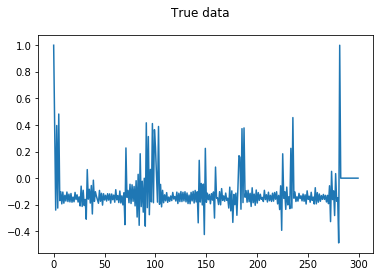

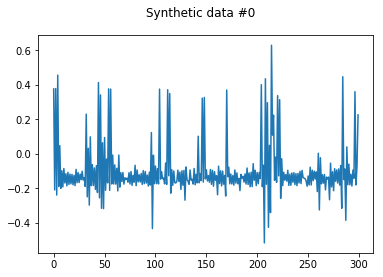

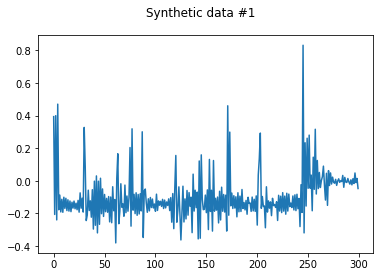

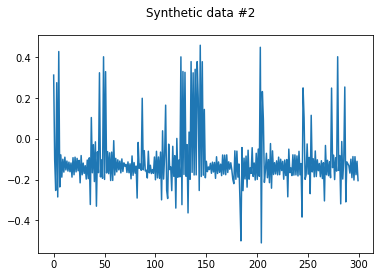

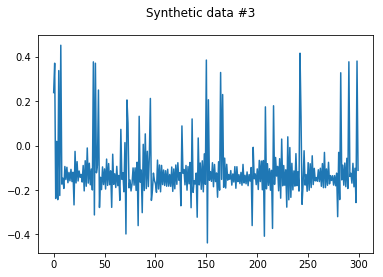

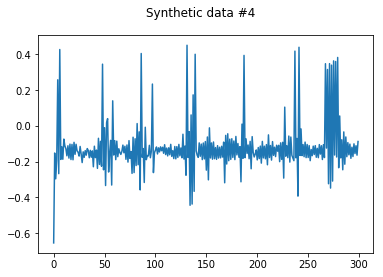

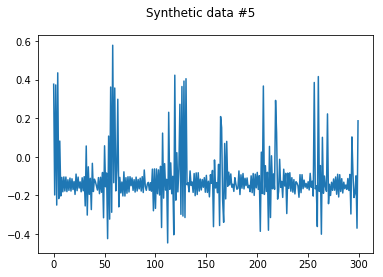

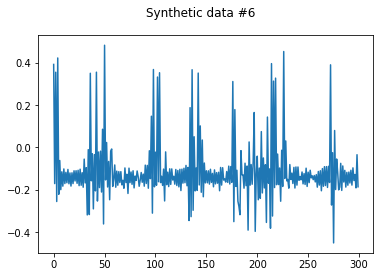

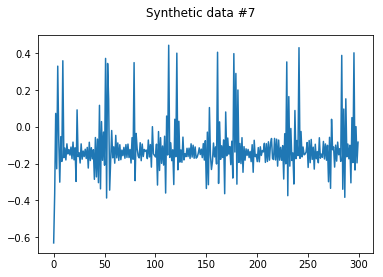

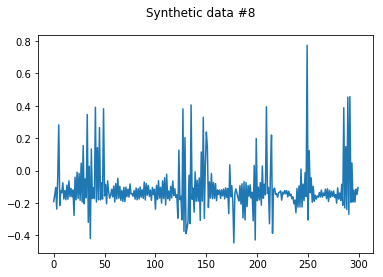

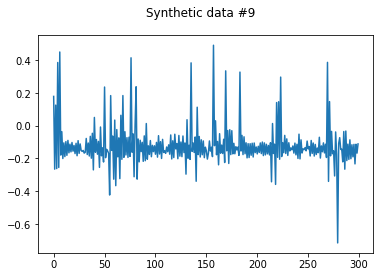

In [14]:
ckpt_path = f'{MODEL_DEST}/mdnmodel_{label}.ckpt'
true_data = data[0]
fig = plt.figure()
plt.plot(true_data)
fig.suptitle('True data')
if not os.path.exists(DEST):
    os.makedirs(DEST)
for structure in range(N_STRUCTURES):
    reset_session_and_model()
    with tf.Session() as sess:
        test_model = MDNModel(test_config, True)
        test_model.is_training = False
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        saver.restore(sess, ckpt_path)
        fake_data = test_model.predict(sess, SEQ_LEN)
    fig = plt.figure()
    plt.plot(fake_data)
    zf_label = str(structure).zfill(len(str(N_STRUCTURES-1)))
    fig.suptitle(f'Synthetic data #{zf_label}')
    plt.savefig(f'{DEST}/structure_{label}_{zf_label}.png')
    np.savetxt(f'{DEST}/result_{label}_{zf_label}.txt', np.array(fake_data).reshape((MAX_ATOMS, 2)), delimiter=';')
plt.show()

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [ ]:
# Ensure proper save
time.sleep(10)

In [ ]:
# Folder zipping routine
def pack_dir(zf, folder):
    for dirname, subdirs, files in os.walk(folder):
        zf.write(dirname)
        for filename in files:
            zf.write(os.path.join(dirname, filename))

In [ ]:
# Prepare archive of model and prediction data
if not os.path.exists(ZIP_DEST):
    os.makedirs(ZIP_DEST)
zf = zipfile.ZipFile(f'{ZIP_DEST}/{label}.zip', 'w')
pack_dir(zf, DEST)
pack_dir(zf, MODEL_DEST)
zf.write(nb_name)
zf.close()

In [ ]:
# Cleanup model and prediction data if needed
if CLEANUP:
    shutil.rmtree(MODEL_DEST)
    shutil.rmtree(DEST)